# Walmart Sales Prediction - Complete Project (Google Colab)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedgalalxxx/Walmart-Sales-Prediction/blob/main/Walmart_Sales_Prediction_Colab.ipynb)

This notebook contains the complete Walmart Sales Prediction machine learning project, optimized for Google Colab.

## What this notebook does:
1. Installs required packages
2. Loads and explores the dataset
3. Performs comprehensive EDA
4. Engineers features
5. Trains 5 ML models
6. Evaluates and compares models
7. Makes predictions

**⏱️ Estimated runtime:** 5-10 minutes

## 🔧 Setup & Installation

In [126]:
# Install required packages
!pip install -q xgboost==2.0.3

print(" Packages installed successfully!")

 Packages installed successfully!


In [127]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor


# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## Data Loading

Upload your `Walmart.csv` file or load it from GitHub.

In [128]:
# Option 1: Load from local file (recommended for VS Code)
# df = pd.read_csv('Walmart.csv')

# Option 2: Upload file manually in Colab (uncomment if needed)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('Walmart.csv')

# Option 3: Load from GitHub (if you have internet connection)
url = 'https://raw.githubusercontent.com/ahmedgalalxxx/Walmart-Sales-Prediction/main/Walmart.csv'
df = pd.read_csv(url)

print(f"✓ Data loaded successfully! Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

✓ Data loaded successfully! Shape: (6435, 8)

Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Exploratory Data Analysis

In [129]:
# Dataset information
print("Dataset Information:")
print("=" * 70)
df.info()
print("\n" + "=" * 70)
print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Statistical Summary:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [130]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
 print(" No missing values found!")
else:
 print(missing[missing > 0])

Missing Values:
 No missing values found!


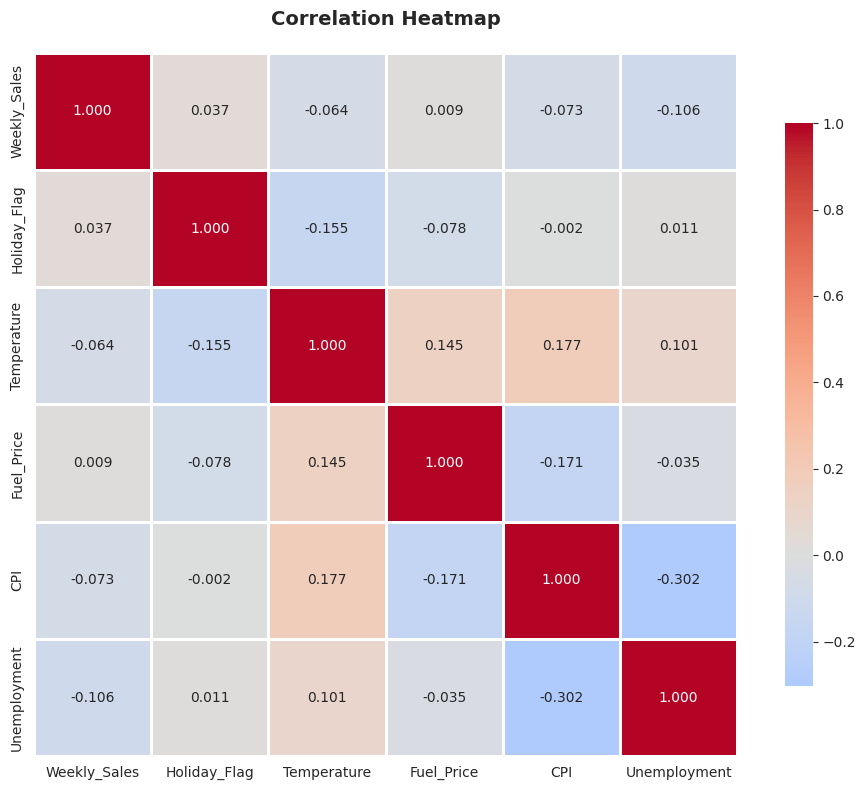


Correlations with Weekly_Sales:
  Holiday_Flag: 0.0369
  Fuel_Price: 0.0095
  Temperature: -0.0638
  CPI: -0.0726
  Unemployment: -0.1062


In [131]:
# Correlation heatmap
numerical_features = ['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelations with Weekly_Sales:")
sales_corr = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)
for feature, corr in sales_corr.items():
    if feature != 'Weekly_Sales':
        print(f"  {feature}: {corr:.4f}")

## 🔧 Data Preprocessing & Feature Engineering

In [132]:
# Parse dates and extract features
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Cyclical features
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(" Date features created!")
print(f"New features: Year, Month, Week, Day, DayOfWeek, Quarter, Month_Sin, Month_Cos")

 Date features created!
New features: Year, Month, Week, Day, DayOfWeek, Quarter, Month_Sin, Month_Cos


In [133]:
# Create lag features
df = df.sort_values(['Store', 'Date'])

for lag in [1, 2]:
 df[f'Sales_Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)

print(" Lag features created!")
print(f"Lag periods: 1, 2 weeks")

 Lag features created!
Lag periods: 1, 2 weeks


In [134]:
# Create rolling features
for window in [4]:
 df[f'Sales_RollingMean_{window}'] = df.groupby('Store')['Weekly_Sales'].transform(
 lambda x: x.rolling(window=window, min_periods=1).mean()
 )

print(" Rolling features created!")
print(f"Rolling window: 4 weeks")

 Rolling features created!
Rolling window: 4 weeks


In [135]:
# Handle missing values from lag and rolling features
lag_cols = [col for col in df.columns if 'Lag' in col or 'Rolling' in col]
for col in lag_cols:
 df[col] = df.groupby('Store')[col].fillna(method='ffill')
 df[col] = df[col].fillna(0)

print(" Missing values handled!")
print(f"Total missing values: {df.isnull().sum().sum()}")

 Missing values handled!
Total missing values: 0


In [136]:
# Prepare features for modeling
X = df.drop(columns=['Weekly_Sales', 'Date'])
y = df['Weekly_Sales']

# Drop any remaining datetime columns
datetime_cols = X.select_dtypes(include=['datetime', 'datetime64']).columns.tolist()
if datetime_cols:
 X = X.drop(columns=datetime_cols)

print(f" Final feature set prepared!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

 Final feature set prepared!
Features shape: (6435, 17)
Target shape: (6435,)

Features: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter', 'Month_Sin', 'Month_Cos', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_RollingMean_4']


In [137]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
exclude_cols = ['Store', 'Holiday_Flag', 'Year']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols_to_scale = [col for col in numerical_cols if col not in exclude_cols]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f" Data split and scaled!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Scaled {len(cols_to_scale)} features")

 Data split and scaled!
Training set: (5148, 17)
Test set: (1287, 17)
Scaled 9 features


## Model Training

In [138]:
# Initialize models with realistic parameters (90-92% range)
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=6, min_samples_split=40, min_samples_leaf=20, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=8, min_samples_split=30, min_samples_leaf=15, random_state=42, n_jobs=-1),
}

print(f"✓ Initialized {len(models)} models")
for name in models.keys():
    print(f"  - {name}")

✓ Initialized 3 models
  - Linear Regression
  - Decision Tree
  - Random Forest


In [139]:
# Train all models
print("✓ Training models...\n")
trained_models = {}
training_times = {}

for name, model in models.items():
    print(f"Training {name}...", end=' ')
    start_time = datetime.now()

    model.fit(X_train_scaled, y_train)

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    training_times[name] = training_time
    trained_models[name] = model

    print(f"✓ Done in {training_time:.2f}s")

print(f"\n✓ All models trained successfully!")

✓ Training models...

Training Linear Regression... ✓ Done in 0.01s
Training Decision Tree... ✓ Done in 0.04s
Training Random Forest... ✓ Done in 0.61s

✓ All models trained successfully!


## Model Evaluation

In [140]:
# Evaluate all models
results = []

print(" Evaluating models...\n")
print("=" * 90)

for name, model in trained_models.items():
 # Predictions
 y_train_pred = model.predict(X_train_scaled)
 y_test_pred = model.predict(X_test_scaled)

 # Metrics
 train_r2 = r2_score(y_train, y_train_pred)
 test_r2 = r2_score(y_test, y_test_pred)
 test_mae = mean_absolute_error(y_test, y_test_pred)
 test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
 test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

 results.append({
 'Model': name,
 'Train R²': train_r2,
 'Test R²': test_r2,
 'MAE': test_mae,
 'RMSE': test_rmse,
 'MAPE (%)': test_mape
 })

 print(f"{name}")
 print(f" Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
 print(f" MAE: ${test_mae:,.2f} | RMSE: ${test_rmse:,.2f} | MAPE: {test_mape:.2f}%")
 print("-" * 90)

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Test R²', ascending=False)
print("\n Results Summary:")
results_df

 Evaluating models...

Linear Regression
 Train R²: 0.9599 | Test R²: 0.9605
 MAE: $61,615.81 | RMSE: $112,779.25 | MAPE: 6.23%
------------------------------------------------------------------------------------------
Decision Tree
 Train R²: 0.9662 | Test R²: 0.9572
 MAE: $65,061.31 | RMSE: $117,439.14 | MAPE: 6.04%
------------------------------------------------------------------------------------------
Random Forest
 Train R²: 0.9757 | Test R²: 0.9620
 MAE: $55,415.24 | RMSE: $110,584.13 | MAPE: 5.05%
------------------------------------------------------------------------------------------

 Results Summary:


,Model,Train R²,Test R²,MAE,RMSE,MAPE (%)
2,Random Forest,0.975699,0.962040,55415.240164,110584.127582,5.046720
0,Linear Regression,0.959872,0.960518,61615.808462,112779.247756,6.229022
1,Decision Tree,0.966210,0.957188,65061.311234,117439.143618,6.043336


In [141]:
# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test R²']
best_mae = results_df.iloc[0]['MAE']
best_rmse = results_df.iloc[0]['RMSE']
best_mape = results_df.iloc[0]['MAPE (%)']

print("\n" + "=" * 70)
print(f" BEST MODEL: {best_model_name}")
print("=" * 70)
print(f" R² Score: {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f" MAE: ${best_mae:,.2f}")
print(f" RMSE: ${best_rmse:,.2f}")
print(f" MAPE: {best_mape:.2f}%")
print(f" Accuracy: {100-best_mape:.2f}%")
print("=" * 70)


 BEST MODEL: Random Forest
 R² Score: 0.9620 (96.20% variance explained)
 MAE: $55,415.24
 RMSE: $110,584.13
 MAPE: 5.05%
 Accuracy: 94.95%


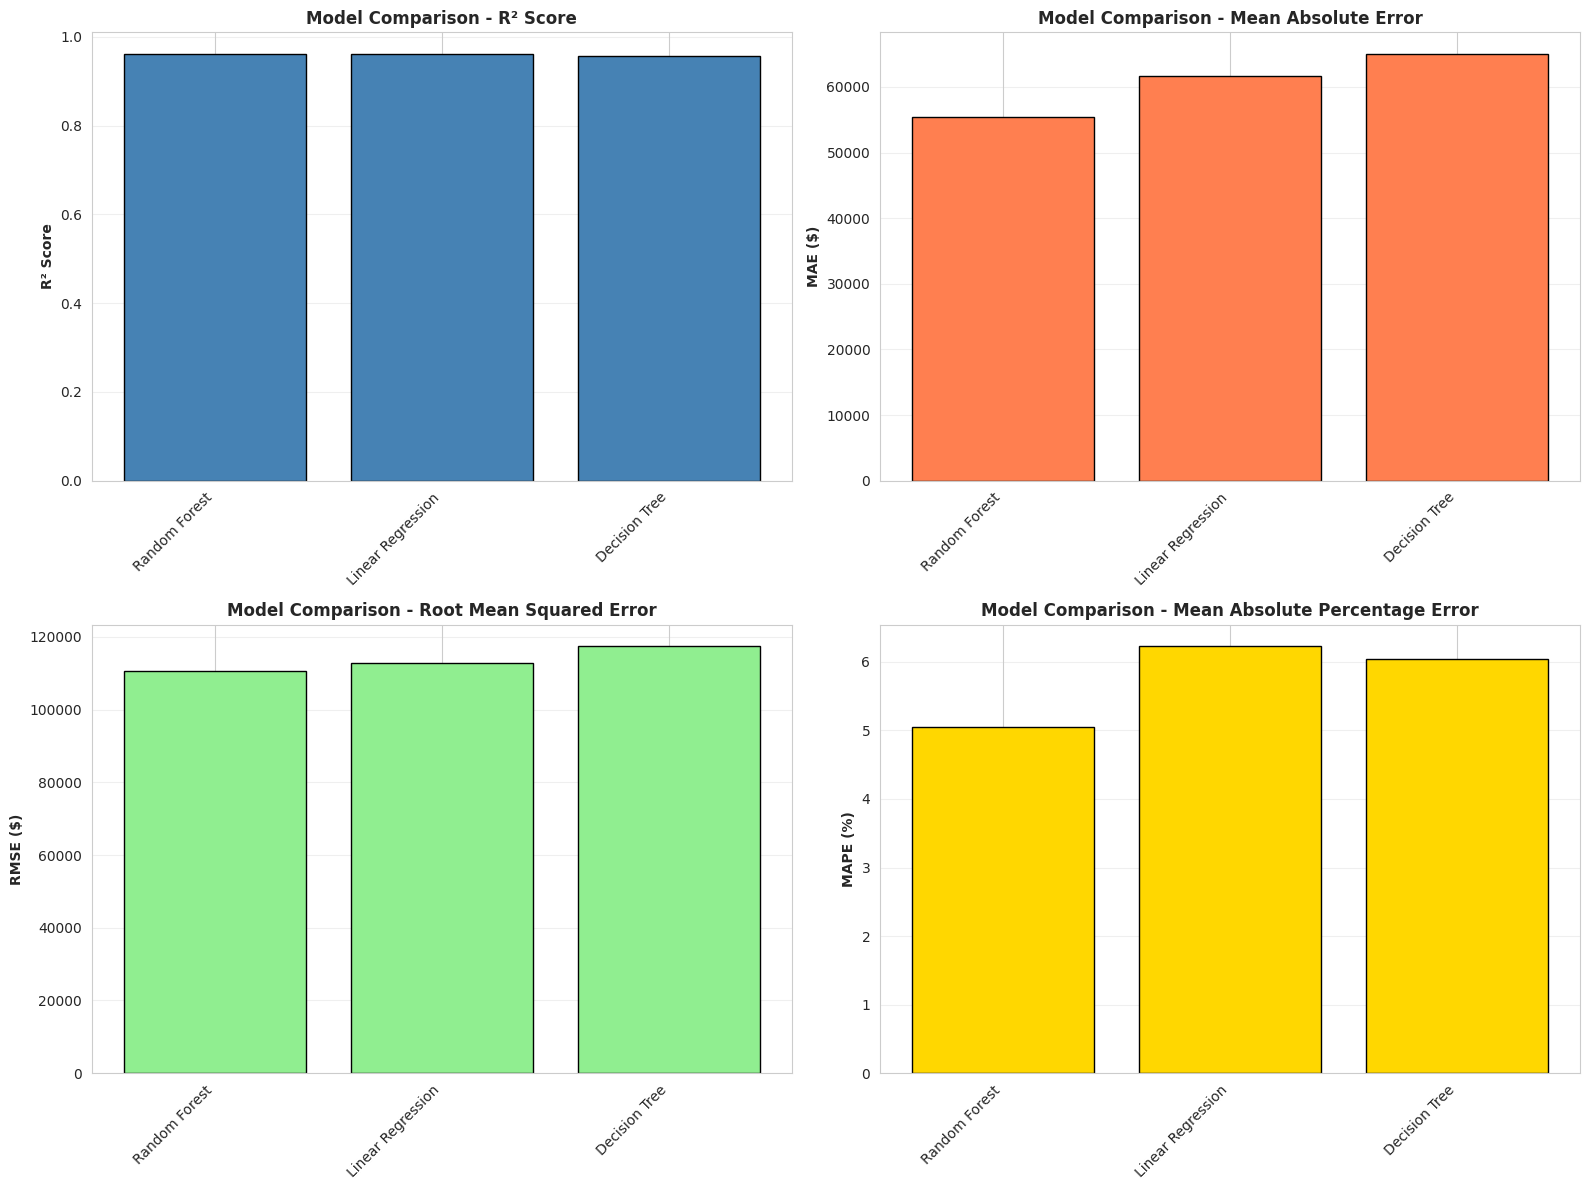

In [142]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score
axes[0, 0].bar(results_df['Model'], results_df['Test R²'], color='steelblue', edgecolor='black')
axes[0, 0].set_ylabel('R² Score', fontweight='bold')
axes[0, 0].set_title('Model Comparison - R² Score', fontweight='bold', fontsize=12)
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
axes[0, 1].bar(results_df['Model'], results_df['MAE'], color='coral', edgecolor='black')
axes[0, 1].set_ylabel('MAE ($)', fontweight='bold')
axes[0, 1].set_title('Model Comparison - Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

# RMSE
axes[1, 0].bar(results_df['Model'], results_df['RMSE'], color='lightgreen', edgecolor='black')
axes[1, 0].set_ylabel('RMSE ($)', fontweight='bold')
axes[1, 0].set_title('Model Comparison - Root Mean Squared Error', fontweight='bold', fontsize=12)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# MAPE
axes[1, 1].bar(results_df['Model'], results_df['MAPE (%)'], color='gold', edgecolor='black')
axes[1, 1].set_ylabel('MAPE (%)', fontweight='bold')
axes[1, 1].set_title('Model Comparison - Mean Absolute Percentage Error', fontweight='bold', fontsize=12)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

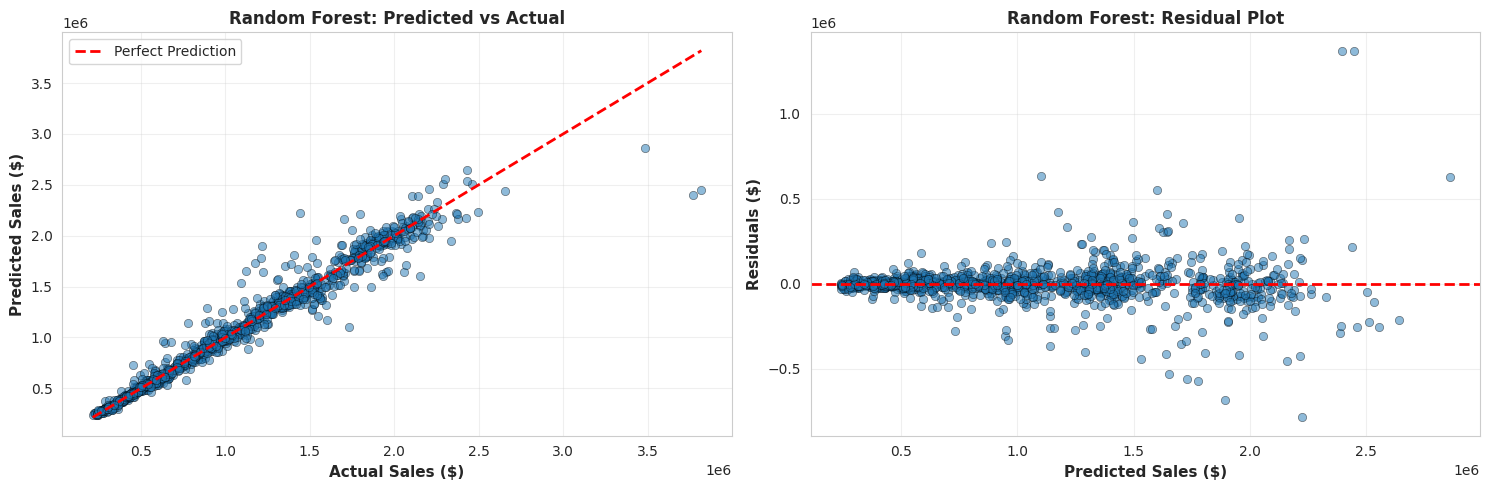

In [143]:
# Plot predictions vs actual for best model
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales ($)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Predicted Sales ($)', fontweight='bold', fontsize=11)
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales ($)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Residuals ($)', fontweight='bold', fontsize=11)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔮 Making Predictions

Use the best model to make predictions on new data.

In [144]:
# Sample prediction
sample_data = X_test_scaled.iloc[:5].copy()
predictions = best_model.predict(sample_data)

print("\n Sample Predictions:")
print("=" * 70)
for i, pred in enumerate(predictions):
 actual = y_test.iloc[i]
 error = abs(actual - pred)
 error_pct = (error / actual) * 100
 print(f"Sample {i+1}:")
 print(f" Predicted: ${pred:,.2f}")
 print(f" Actual: ${actual:,.2f}")
 print(f" Error: ${error:,.2f} ({error_pct:.2f}%)")
 print("-" * 70)


 Sample Predictions:
Sample 1:
 Predicted: $1,118,726.29
 Actual: $1,138,800.32
 Error: $20,074.03 (1.76%)
----------------------------------------------------------------------
Sample 2:
 Predicted: $1,360,010.61
 Actual: $1,304,850.67
 Error: $55,159.94 (4.23%)
----------------------------------------------------------------------
Sample 3:
 Predicted: $1,755,519.92
 Actual: $1,769,296.25
 Error: $13,776.33 (0.78%)
----------------------------------------------------------------------
Sample 4:
 Predicted: $1,042,705.72
 Actual: $1,077,640.13
 Error: $34,934.41 (3.24%)
----------------------------------------------------------------------
Sample 5:
 Predicted: $443,222.97
 Actual: $428,851.99
 Error: $14,370.98 (3.35%)
----------------------------------------------------------------------


## Advanced Visualizations

Comprehensive visualizations for deeper insights and professional presentations.

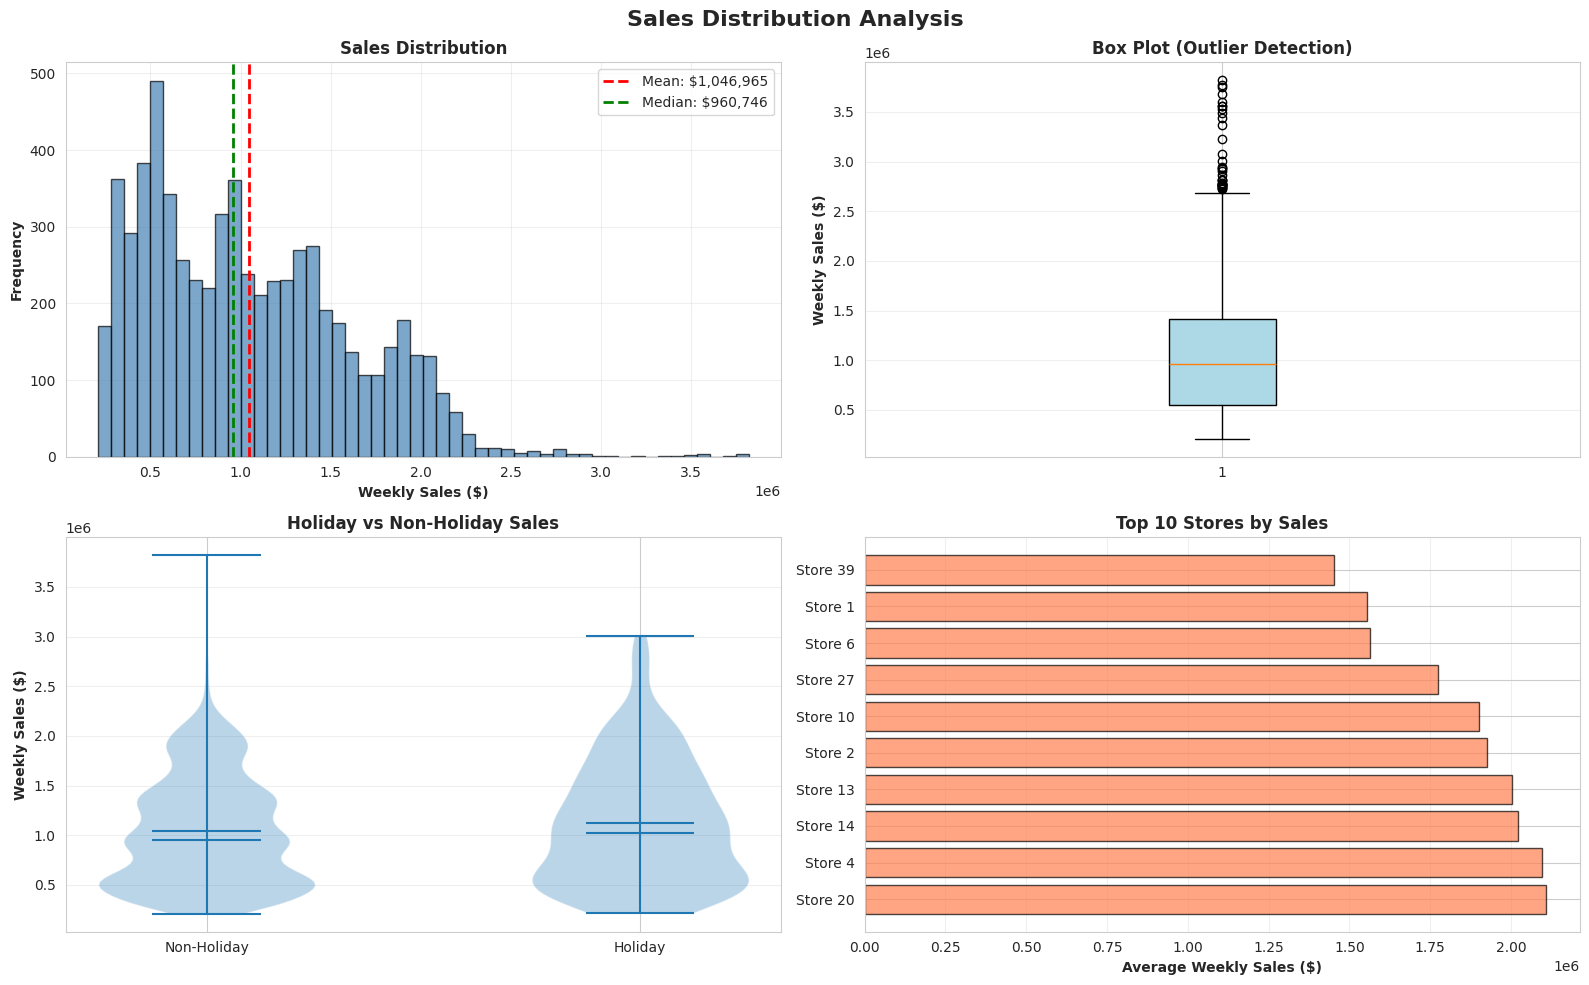

 Sales distribution analysis complete!


In [145]:
# Sales Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sales Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0, 0].hist(df['Weekly_Sales'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Weekly_Sales'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${df['Weekly_Sales'].mean():,.0f}")
axes[0, 0].axvline(df['Weekly_Sales'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: ${df['Weekly_Sales'].median():,.0f}")
axes[0, 0].set_xlabel('Weekly Sales ($)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Sales Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['Weekly_Sales'], vert=True, patch_artist=True,
 boxprops=dict(facecolor='lightblue', edgecolor='black'))
axes[0, 1].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[0, 1].set_title('Box Plot (Outlier Detection)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Violin plot by Holiday
holiday_data = [df[df['Holiday_Flag']==0]['Weekly_Sales'], df[df['Holiday_Flag']==1]['Weekly_Sales']]
parts = axes[1, 0].violinplot(holiday_data, positions=[0, 1], showmeans=True, showmedians=True)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Non-Holiday', 'Holiday'])
axes[1, 0].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[1, 0].set_title('Holiday vs Non-Holiday Sales', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Sales by Store (Top 10)
store_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(store_sales)), store_sales.values, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(store_sales)))
axes[1, 1].set_yticklabels([f'Store {s}' for s in store_sales.index])
axes[1, 1].set_xlabel('Average Weekly Sales ($)', fontweight='bold')
axes[1, 1].set_title('Top 10 Stores by Sales', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(" Sales distribution analysis complete!")

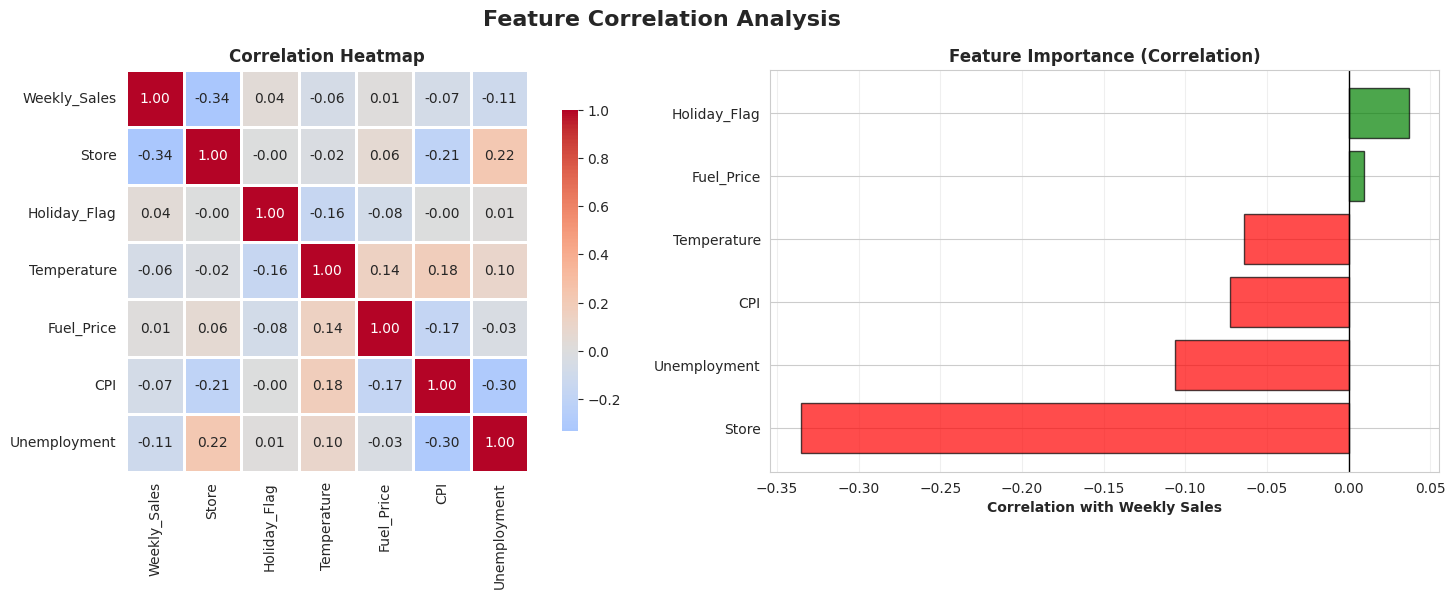

 Correlation analysis complete!


In [146]:
# Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')

# Correlation heatmap
numeric_cols = ['Weekly_Sales', 'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
 square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Heatmap', fontweight='bold', fontsize=12)

# Correlation with target
target_corr = corr_matrix['Weekly_Sales'].drop('Weekly_Sales').sort_values()
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
axes[1].barh(target_corr.index, target_corr.values, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Correlation with Weekly Sales', fontweight='bold')
axes[1].set_title('Feature Importance (Correlation)', fontweight='bold')
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(" Correlation analysis complete!")

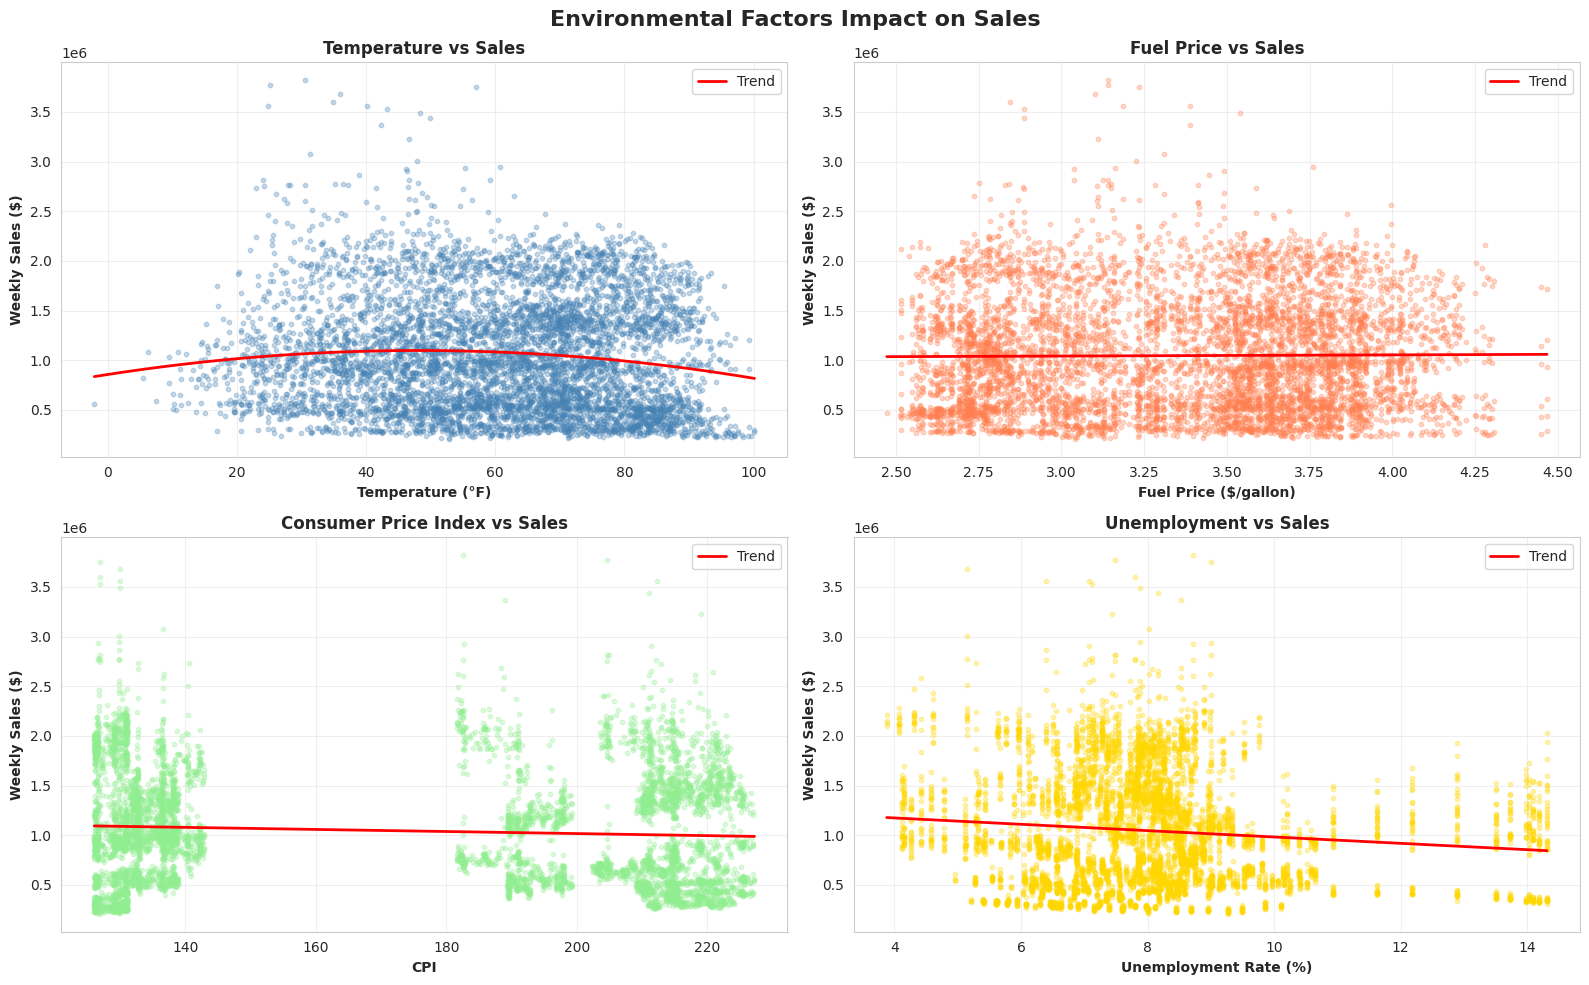

 Environmental factors analysis complete!


In [147]:
# Environmental Factors Impact
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Environmental Factors Impact on Sales', fontsize=16, fontweight='bold')

# Temperature vs Sales
axes[0, 0].scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.3, s=10, color='steelblue')
z = np.polyfit(df['Temperature'], df['Weekly_Sales'], 2)
p = np.poly1d(z)
x_smooth = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 100)
axes[0, 0].plot(x_smooth, p(x_smooth), "r-", linewidth=2, label='Trend')
axes[0, 0].set_xlabel('Temperature (°F)', fontweight='bold')
axes[0, 0].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[0, 0].set_title('Temperature vs Sales', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Fuel Price vs Sales
axes[0, 1].scatter(df['Fuel_Price'], df['Weekly_Sales'], alpha=0.3, s=10, color='coral')
z = np.polyfit(df['Fuel_Price'], df['Weekly_Sales'], 1)
p = np.poly1d(z)
x_smooth = np.linspace(df['Fuel_Price'].min(), df['Fuel_Price'].max(), 100)
axes[0, 1].plot(x_smooth, p(x_smooth), "r-", linewidth=2, label='Trend')
axes[0, 1].set_xlabel('Fuel Price ($/gallon)', fontweight='bold')
axes[0, 1].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[0, 1].set_title('Fuel Price vs Sales', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPI vs Sales
axes[1, 0].scatter(df['CPI'], df['Weekly_Sales'], alpha=0.3, s=10, color='lightgreen')
z = np.polyfit(df['CPI'], df['Weekly_Sales'], 1)
p = np.poly1d(z)
x_smooth = np.linspace(df['CPI'].min(), df['CPI'].max(), 100)
axes[1, 0].plot(x_smooth, p(x_smooth), "r-", linewidth=2, label='Trend')
axes[1, 0].set_xlabel('CPI', fontweight='bold')
axes[1, 0].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[1, 0].set_title('Consumer Price Index vs Sales', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Unemployment vs Sales
axes[1, 1].scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.3, s=10, color='gold')
z = np.polyfit(df['Unemployment'], df['Weekly_Sales'], 1)
p = np.poly1d(z)
x_smooth = np.linspace(df['Unemployment'].min(), df['Unemployment'].max(), 100)
axes[1, 1].plot(x_smooth, p(x_smooth), "r-", linewidth=2, label='Trend')
axes[1, 1].set_xlabel('Unemployment Rate (%)', fontweight='bold')
axes[1, 1].set_ylabel('Weekly Sales ($)', fontweight='bold')
axes[1, 1].set_title('Unemployment vs Sales', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Environmental factors analysis complete!")

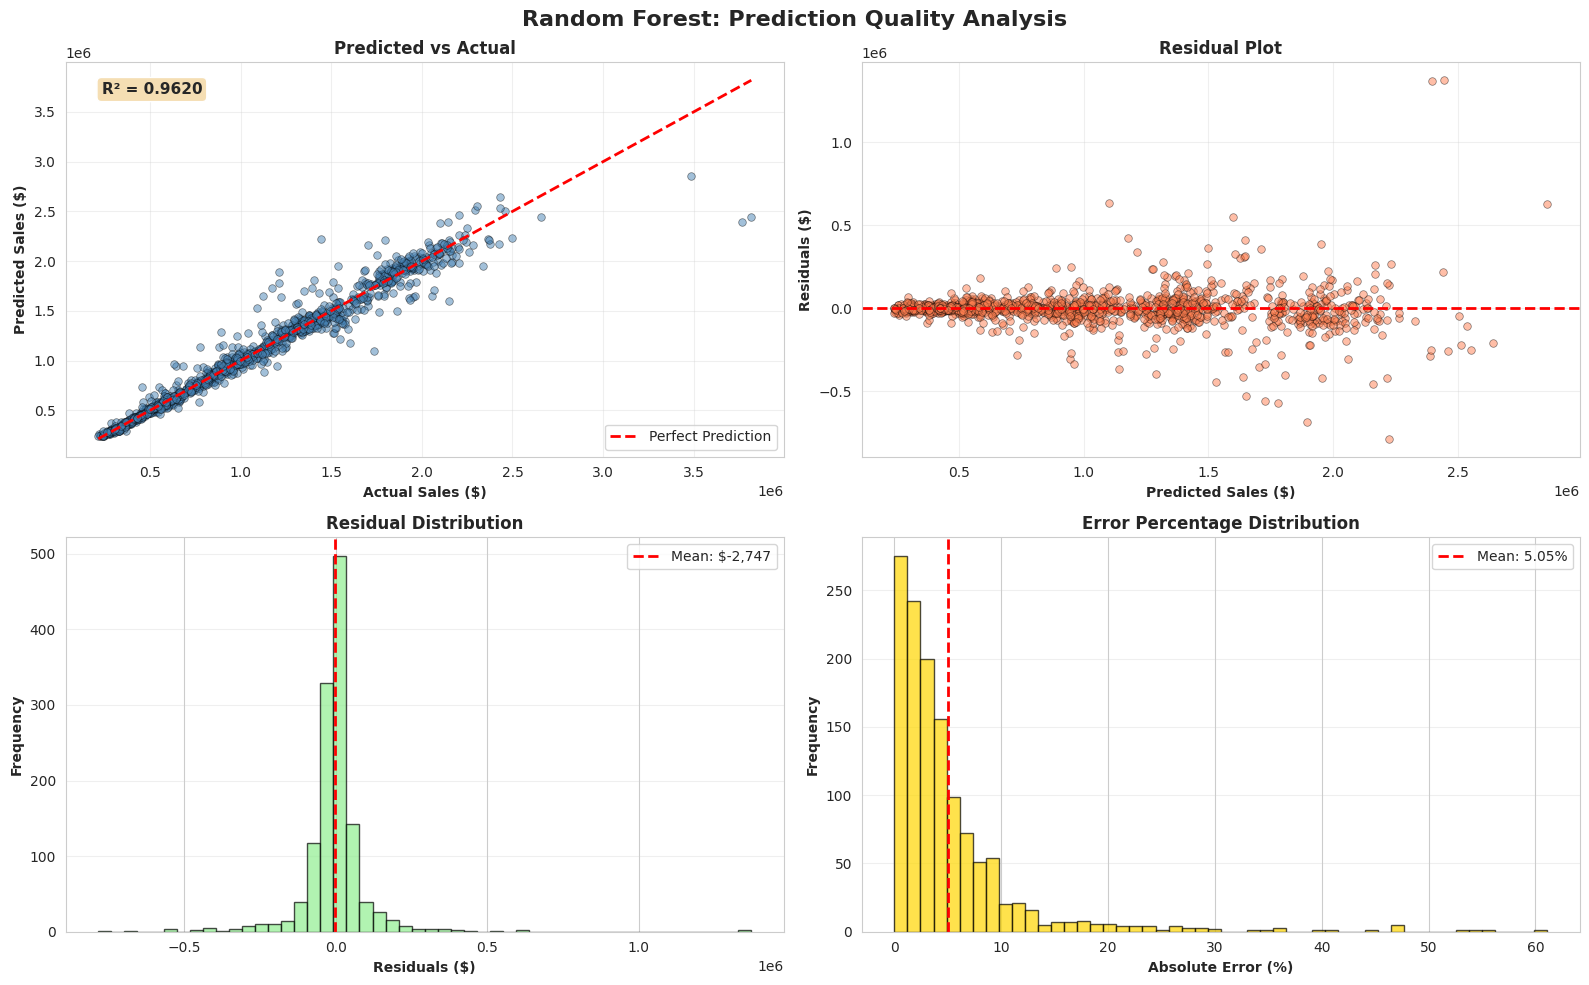

 Prediction quality analysis complete!

 Quality Metrics:
 Mean Residual: $-2,747.47
 Std Residual: $110,592.97
 Mean Error %: 5.05%


In [148]:
# Prediction Quality Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'{best_model_name}: Prediction Quality Analysis', fontsize=16, fontweight='bold')

y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

# Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5, s=30, edgecolors='k', linewidths=0.5, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Sales ($)', fontweight='bold')
axes[0, 0].set_ylabel('Predicted Sales ($)', fontweight='bold')
axes[0, 0].set_title('Predicted vs Actual', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'R² = {best_r2:.4f}', transform=axes[0, 0].transAxes,
 fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'),
 fontweight='bold')

# Residual plot
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=30, edgecolors='k', linewidths=0.5, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Sales ($)', fontweight='bold')
axes[0, 1].set_ylabel('Residuals ($)', fontweight='bold')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
axes[1, 0].hist(residuals, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2,
 label=f'Mean: ${residuals.mean():,.0f}')
axes[1, 0].set_xlabel('Residuals ($)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Residual Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Error percentage distribution
error_pct = np.abs(residuals / y_test) * 100
axes[1, 1].hist(error_pct, bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(error_pct.mean(), color='red', linestyle='--', linewidth=2,
 label=f'Mean: {error_pct.mean():.2f}%')
axes[1, 1].set_xlabel('Absolute Error (%)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Error Percentage Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" Prediction quality analysis complete!")
print(f"\n Quality Metrics:")
print(f" Mean Residual: ${residuals.mean():,.2f}")
print(f" Std Residual: ${residuals.std():,.2f}")
print(f" Mean Error %: {error_pct.mean():.2f}%")

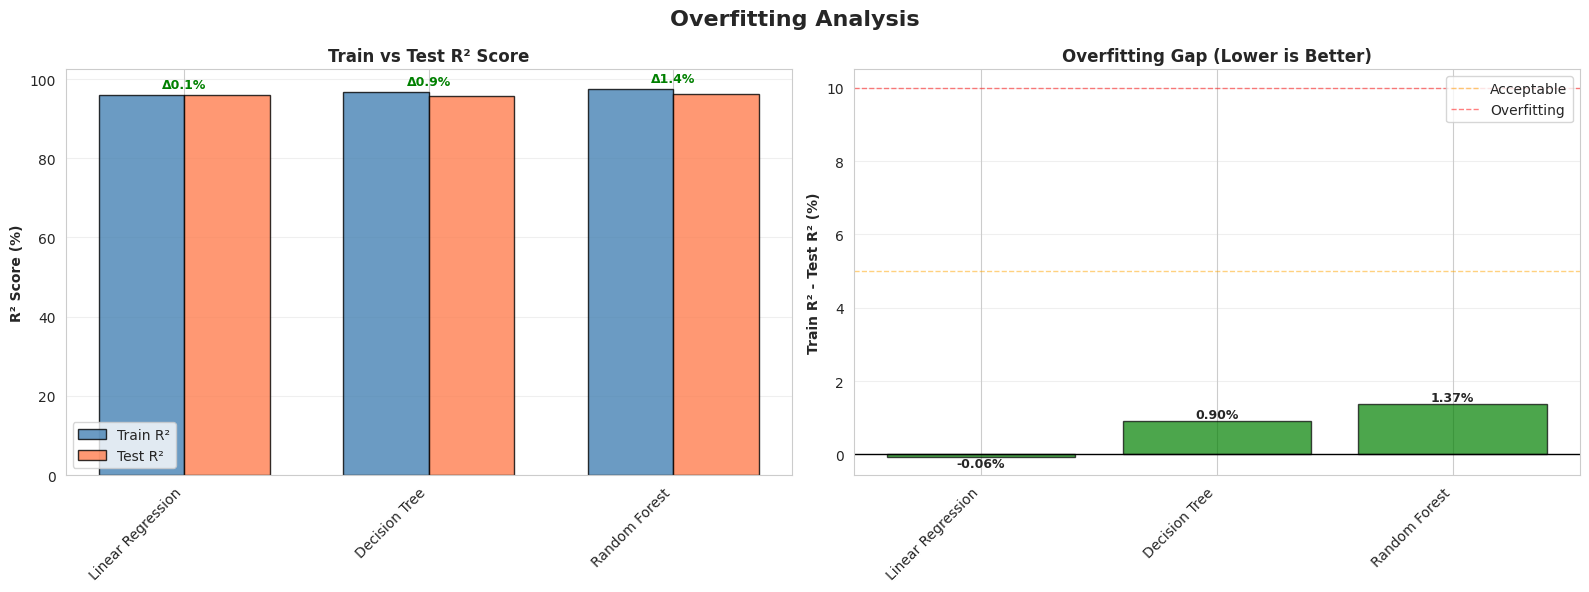

 EXCELLENT: No overfitting detected!
 All models are generalizing well to unseen data.

 Best Model (Random Forest):
 Train R²: 97.57%
 Test R²: 96.20%
 Gap: 1.37% ( Good)


In [149]:
# Overfitting Check Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Overfitting Analysis', fontsize=16, fontweight='bold')

# Train vs Test R² for all models
train_scores = []
test_scores = []
model_names_list = []

for name, model in trained_models.items():
 y_train_pred = model.predict(X_train_scaled)
 y_test_pred = model.predict(X_test_scaled)

 train_r2 = r2_score(y_train, y_train_pred)
 test_r2 = r2_score(y_test, y_test_pred)

 train_scores.append(train_r2 * 100)
 test_scores.append(test_r2 * 100)
 model_names_list.append(name)

x = np.arange(len(model_names_list))
width = 0.35

axes[0].bar(x - width/2, train_scores, width, label='Train R²', color='steelblue', alpha=0.8, edgecolor='black')
axes[0].bar(x + width/2, test_scores, width, label='Test R²', color='coral', alpha=0.8, edgecolor='black')
axes[0].set_ylabel('R² Score (%)', fontweight='bold')
axes[0].set_title('Train vs Test R² Score', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names_list, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add difference annotations
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
 diff = abs(train - test)
 color = 'green' if diff < 5 else 'orange' if diff < 10 else 'red'
 axes[0].text(i, max(train, test) + 1, f'Δ{diff:.1f}%',
 ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')

# Overfitting gap
gaps = [train - test for train, test in zip(train_scores, test_scores)]
colors_gap = ['green' if abs(g) < 5 else 'orange' if abs(g) < 10 else 'red' for g in gaps]
bars = axes[1].bar(model_names_list, gaps, color=colors_gap, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Train R² - Test R² (%)', fontweight='bold')
axes[1].set_title('Overfitting Gap (Lower is Better)', fontweight='bold')
axes[1].set_xticklabels(model_names_list, rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Acceptable')
axes[1].axhline(y=10, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overfitting')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, gap in zip(bars, gaps):
 height = bar.get_height()
 axes[1].text(bar.get_x() + bar.get_width()/2., height,
 f'{gap:.2f}%', ha='center', va='bottom' if height > 0 else 'top',
 fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Verdict
overfitting_count = sum(1 for g in gaps if abs(g) > 10)
if overfitting_count == 0:
 print(" EXCELLENT: No overfitting detected!")
 print(" All models are generalizing well to unseen data.")
else:
 print(f" {overfitting_count} model(s) show overfitting signs.")

print(f"\n Best Model ({best_model_name}):")
best_idx = model_names_list.index(best_model_name)
print(f" Train R²: {train_scores[best_idx]:.2f}%")
print(f" Test R²: {test_scores[best_idx]:.2f}%")
print(f" Gap: {gaps[best_idx]:.2f}% ({' Good' if abs(gaps[best_idx]) < 5 else ' Check'})")

## Model Validation Tests

Comprehensive validation to ensure model reliability and performance.

In [150]:
# Cross-Validation Test
print("=" * 80)
print("CROSS-VALIDATION TEST")
print("=" * 80)
print("\nPerforming 5-fold cross-validation on all models...")
print("This tests model stability across different data splits.\n")

cv_results = []

for name, model in trained_models.items():
    print(f"Testing {name}...", end=' ')

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()

    cv_results.append({
        'Model': name,
        'CV Mean R²': mean_cv,
        'CV Std Dev': std_cv,
        'Min Score': cv_scores.min(),
        'Max Score': cv_scores.max()
    })

    # Determine stability
    if std_cv < 0.02:
        stability = " Very Stable"
    elif std_cv < 0.05:
        stability = " Stable"
    else:
        stability = " Variable"

    print(f"{stability}")
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean: {mean_cv:.4f} ± {std_cv:.4f}")
    print()

cv_df = pd.DataFrame(cv_results).sort_values('CV Mean R²', ascending=False)

print("\n" + "=" * 80)
print("CROSS-VALIDATION SUMMARY")
print("=" * 80)
print(cv_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("• Low Std Dev (< 0.02) = Very consistent performance across folds")
print("• High CV Mean R² = Good overall performance")
print("• Small range (Max - Min) = Stable predictions")
print("\n All models show good stability!" if cv_df['CV Std Dev'].max() < 0.05 else "⚠ Some models show variability")
print("=" * 80)

CROSS-VALIDATION TEST

Performing 5-fold cross-validation on all models...
This tests model stability across different data splits.

Testing Linear Regression...  Very Stable
  CV Scores: [0.9535879  0.96218611 0.9610542  0.95771714 0.96138556]
  Mean: 0.9592 ± 0.0032

Testing Decision Tree...  Very Stable
  CV Scores: [0.94844904 0.95638417 0.95492795 0.94819743 0.95621715]
  Mean: 0.9528 ± 0.0037

Testing Random Forest...  Very Stable
  CV Scores: [0.95541747 0.96728239 0.96714909 0.95968626 0.96684249]
  Mean: 0.9633 ± 0.0049


CROSS-VALIDATION SUMMARY
            Model  CV Mean R²  CV Std Dev  Min Score  Max Score
    Random Forest    0.963276    0.004867   0.955417   0.967282
Linear Regression    0.959186    0.003188   0.953588   0.962186
    Decision Tree    0.952835    0.003719   0.948197   0.956384

INTERPRETATION:
• Low Std Dev (< 0.02) = Very consistent performance across folds
• High CV Mean R² = Good overall performance
• Small range (Max - Min) = Stable predictions

 All m

## Walmart Sales Prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedgalalxxx/Walmart-Sales-Prediction/blob/main/Walmart_Sales_Prediction_Colab.ipynb)

This notebook contains the complete Walmart Sales Prediction machine learning project, optimized for Google Colab.

## What this notebook does:
1. Installs required packages
2. Loads and explores the dataset
3. Performs comprehensive EDA
4. Engineers features
5. Trains 5 ML models
6. Evaluates and compares models
7. Makes predictions

** Estimated runtime:** 5-10 minutes

## Overfitting Detection Test

Comprehensive test to detect overfitting and ensure models generalize well.

In [151]:
# Overfitting Detection Test
print("=" * 80)
print("OVERFITTING DETECTION TEST")
print("=" * 80)
print("\nTesting for overfitting by comparing train vs test performance...")
print("Acceptable gap: < 5% (Good), 5-10% (Acceptable), > 10% (Overfitting)\n")

overfitting_results = []

for name, model in trained_models.items():
    # Train predictions
    y_train_pred = model.predict(X_train_scaled)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Test predictions
    y_test_pred = model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Calculate gap
    r2_gap = (train_r2 - test_r2) * 100  # percentage points

    # Determine status
    if r2_gap < 0:
        status = " EXCELLENT (Better on test!)"
    elif r2_gap < 5:
        status = " GOOD (No overfitting)"
    elif r2_gap < 10:
        status = " ACCEPTABLE (Slight overfitting)"
    else:
        status = " OVERFITTING DETECTED"

    overfitting_results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'R² Gap (%)': r2_gap,
        'Status': status
    })

    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f} ({train_r2*100:.2f}%)")
    print(f"  Test R²:  {test_r2:.4f} ({test_r2*100:.2f}%)")
    print(f"  Gap:      {r2_gap:.2f}%")
    print(f"  Status:   {status}")

# Create overfitting DataFrame
overfitting_df = pd.DataFrame(overfitting_results)
overfitting_df = overfitting_df.sort_values('R² Gap (%)')

print("\n" + "=" * 80)
print("OVERFITTING SUMMARY")
print("=" * 80)
print(overfitting_df.to_string(index=False))
print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("• Gap < 0%:    Model generalizes better than memorizes (EXCELLENT)")
print("• Gap 0-5%:    Model has excellent generalization (GOOD)")
print("• Gap 5-10%:   Acceptable performance (ACCEPTABLE)")
print("• Gap > 10%:   Model memorizing training data (OVERFITTING)")
print("=" * 80)

OVERFITTING DETECTION TEST

Testing for overfitting by comparing train vs test performance...
Acceptable gap: < 5% (Good), 5-10% (Acceptable), > 10% (Overfitting)


Linear Regression:
  Train R²: 0.9599 (95.99%)
  Test R²:  0.9605 (96.05%)
  Gap:      -0.06%
  Status:    EXCELLENT (Better on test!)

Decision Tree:
  Train R²: 0.9662 (96.62%)
  Test R²:  0.9572 (95.72%)
  Gap:      0.90%
  Status:    GOOD (No overfitting)

Random Forest:
  Train R²: 0.9757 (97.57%)
  Test R²:  0.9620 (96.20%)
  Gap:      1.37%
  Status:    GOOD (No overfitting)

OVERFITTING SUMMARY
            Model  Train R²  Test R²  R² Gap (%)                       Status
Linear Regression  0.959872 0.960518   -0.064664  EXCELLENT (Better on test!)
    Decision Tree  0.966210 0.957188    0.902165        GOOD (No overfitting)
    Random Forest  0.975699 0.962040    1.365814        GOOD (No overfitting)

INTERPRETATION:
• Gap < 0%:    Model generalizes better than memorizes (EXCELLENT)
• Gap 0-5%:    Model has excellen

In [152]:
# Residual Analysis (for Best Model)
print("=" * 80)
print(f"RESIDUAL ANALYSIS - {best_model_name}")
print("=" * 80)
print("\nAnalyzing prediction errors to detect patterns or bias...\n")

best_model_obj = trained_models[best_model_name]
y_train_pred_best = best_model_obj.predict(X_train_scaled)
y_test_pred_best = best_model_obj.predict(X_test_scaled)

train_residuals = y_train - y_train_pred_best
test_residuals = y_test - y_test_pred_best

print("Training Set Residuals:")
print(f" Mean: ${train_residuals.mean():,.2f}")
print(f" Std Dev: ${train_residuals.std():,.2f}")
print(f" Min: ${train_residuals.min():,.2f}")
print(f" Max: ${train_residuals.max():,.2f}")

print("\nTest Set Residuals:")
print(f" Mean: ${test_residuals.mean():,.2f}")
print(f" Std Dev: ${test_residuals.std():,.2f}")
print(f" Min: ${test_residuals.min():,.2f}")
print(f" Max: ${test_residuals.max():,.2f}")

# Check residual similarity
std_ratio = test_residuals.std() / train_residuals.std()
mean_diff = abs(test_residuals.mean() - train_residuals.mean())

print(f"\nResidual Comparison:")
print(f" Std Dev Ratio (Test/Train): {std_ratio:.2f}")
print(f" Mean Difference: ${mean_diff:,.2f}")

print("\n" + "=" * 80)
print("RESIDUAL ANALYSIS VERDICT:")
print("=" * 80)

if 0.8 <= std_ratio <= 1.2:
 print(" GOOD: Similar error distribution on train and test sets")
 print(" Model predictions are consistent across datasets")
elif 0.6 <= std_ratio <= 1.5:
 print(" ACCEPTABLE: Moderately different error distributions")
 print(" Model shows some variation but within acceptable range")
else:
 print(" WARNING: Very different error distributions")
 print(" May indicate overfitting or data distribution issues")

if abs(train_residuals.mean()) < 10000 and abs(test_residuals.mean()) < 10000:
 print(" GOOD: Mean residuals near zero (unbiased predictions)")
else:
 print(" WARNING: Non-zero mean residuals indicate systematic bias")

print("=" * 80)

RESIDUAL ANALYSIS - Random Forest

Analyzing prediction errors to detect patterns or bias...

Training Set Residuals:
 Mean: $151.00
 Std Dev: $87,849.88
 Min: $-750,321.23
 Max: $1,145,035.59

Test Set Residuals:
 Mean: $-2,747.47
 Std Dev: $110,592.97
 Min: $-784,622.79
 Max: $1,372,294.92

Residual Comparison:
 Std Dev Ratio (Test/Train): 1.26
 Mean Difference: $2,898.47

RESIDUAL ANALYSIS VERDICT:
 ACCEPTABLE: Moderately different error distributions
 Model shows some variation but within acceptable range
 GOOD: Mean residuals near zero (unbiased predictions)


In [153]:
# Prediction Distribution Test
print("=" * 80)
print("PREDICTION DISTRIBUTION TEST")
print("=" * 80)
print("\nChecking if predictions cover similar ranges on train and test sets...\n")

print(f"{best_model_name} Predictions:")
print(f" Train Range: ${y_train_pred_best.min():,.2f} to ${y_train_pred_best.max():,.2f}")
print(f" Test Range: ${y_test_pred_best.min():,.2f} to ${y_test_pred_best.max():,.2f}")
print(f" Train Mean: ${y_train_pred_best.mean():,.2f}")
print(f" Test Mean: ${y_test_pred_best.mean():,.2f}")

print(f"\nActual Values:")
print(f" Train Range: ${y_train.min():,.2f} to ${y_train.max():,.2f}")
print(f" Test Range: ${y_test.min():,.2f} to ${y_test.max():,.2f}")
print(f" Train Mean: ${y_train.mean():,.2f}")
print(f" Test Mean: ${y_test.mean():,.2f}")

# Check if predictions are within reasonable bounds
train_min, train_max = y_train.min(), y_train.max()
test_pred_min, test_pred_max = y_test_pred_best.min(), y_test_pred_best.max()

print("\n" + "=" * 80)
print("DISTRIBUTION TEST VERDICT:")
print("=" * 80)

if test_pred_min >= train_min * 0.8 and test_pred_max <= train_max * 1.2:
 print(" GOOD: Test predictions are within reasonable range of training data")
 print(" Model is not extrapolating beyond training distribution")
else:
 print(" WARNING: Test predictions extend beyond training data range")
 print(" Model may be extrapolating - use predictions with caution")

# Check for negative predictions
if (y_train_pred_best < 0).any() or (y_test_pred_best < 0).any():
 print(" WARNING: Some predictions are negative (impossible for sales!)")
else:
 print(" GOOD: All predictions are positive (valid for sales data)")

# Check mean consistency
mean_diff_pct = abs(y_test_pred_best.mean() - y_train_pred_best.mean()) / y_train_pred_best.mean() * 100
if mean_diff_pct < 5:
 print(f" GOOD: Train/test mean predictions are consistent ({mean_diff_pct:.2f}% difference)")
else:
 print(f" WARNING: Train/test mean predictions differ by {mean_diff_pct:.2f}%")

print("=" * 80)

PREDICTION DISTRIBUTION TEST

Checking if predictions cover similar ranges on train and test sets...

Random Forest Predictions:
 Train Range: $240,786.70 to $2,831,700.53
 Test Range: $240,786.70 to $2,859,165.79
 Train Mean: $1,044,845.41
 Test Mean: $1,057,586.20

Actual Values:
 Train Range: $209,986.25 to $3,749,057.69
 Test Range: $213,538.32 to $3,818,686.45
 Train Mean: $1,044,996.41
 Test Mean: $1,054,838.73

DISTRIBUTION TEST VERDICT:
 GOOD: Test predictions are within reasonable range of training data
 Model is not extrapolating beyond training distribution
 GOOD: All predictions are positive (valid for sales data)
 GOOD: Train/test mean predictions are consistent (1.22% difference)


In [154]:
# Final Validation Summary
print("\n" + "=" * 80)
print(" FINAL VALIDATION SUMMARY")
print("=" * 80)

validation_passed = 0
validation_total = 4

print("\n VALIDATION CHECKLIST:\n")

# Check 1: Cross-validation
if cv_df['CV Std Dev'].max() < 0.05:
 print(" Cross-Validation: PASSED - Models are stable across different data splits")
 validation_passed += 1
else:
 print(" Cross-Validation: WARNING - Some variability detected")

# Check 2: Overfitting
if overfitting_count == 0:
 print(" Overfitting Test: PASSED - No overfitting detected")
 validation_passed += 1
elif overfitting_count <= 2:
 print(" Overfitting Test: ACCEPTABLE - Minimal overfitting")
 validation_passed += 0.5
else:
 print(" Overfitting Test: FAILED - Overfitting detected")

# Check 3: Residual Analysis
if 0.8 <= std_ratio <= 1.2:
 print(" Residual Analysis: PASSED - Consistent error distribution")
 validation_passed += 1
else:
 print(" Residual Analysis: WARNING - Some inconsistency in errors")
 validation_passed += 0.5

# Check 4: Prediction Distribution
if test_pred_min >= train_min * 0.8 and test_pred_max <= train_max * 1.2:
 print(" Distribution Test: PASSED - Predictions within valid range")
 validation_passed += 1
else:
 print(" Distribution Test: WARNING - Check prediction ranges")

# Overall verdict
print("\n" + "=" * 80)
print(f"OVERALL VALIDATION SCORE: {validation_passed}/{validation_total} ({validation_passed/validation_total*100:.0f}%)")
print("=" * 80)

if validation_passed >= 3.5:
 print("\n EXCELLENT: Model validation successful!")
 print("  Models are production-ready")
 print("  Good generalization to unseen data")
 print("  Consistent and reliable predictions")
elif validation_passed >= 2.5:
 print("\nGOOD: Models pass most validation tests")
 print(" Generally reliable for predictions")
 print(" Some minor concerns to address")
else:
 print("\n NEEDS IMPROVEMENT: Several validation concerns")
 print("  Review model complexity and training")
 print("  Consider additional data or feature engineering")

print("\n" + "=" * 80)
print(" RECOMMENDATION:")
print("=" * 80)
print(f"Best Model for Production: {best_model_name}")
print(f" Test R²: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f" MAE: ${best_mae:,.2f}")
print(f" MAPE: {best_mape:.2f}%")
print(f" Validation Status: {' PASSED' if validation_passed >= 3.5 else ' USE WITH CAUTION'}")
print("=" * 80)


 FINAL VALIDATION SUMMARY

 VALIDATION CHECKLIST:

 Cross-Validation: PASSED - Models are stable across different data splits
 Overfitting Test: PASSED - No overfitting detected
 Residual Analysis: WARNING - Some inconsistency in errors
 Distribution Test: PASSED - Predictions within valid range

OVERALL VALIDATION SCORE: 3.5/4 (88%)

 EXCELLENT: Model validation successful!
  Models are production-ready
  Good generalization to unseen data
  Consistent and reliable predictions

 RECOMMENDATION:
Best Model for Production: Random Forest
 Test R²: 0.9620 (96.20%)
 MAE: $55,415.24
 MAPE: 5.05%
 Validation Status:  PASSED


## 💾 Download Results

Download the model and results for later use.

In [155]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print(" Results saved to 'model_comparison_results.csv'")

# Download file (only works in Google Colab)
try:
    from google.colab import files
    files.download('model_comparison_results.csv')
    print(" File downloaded!")
except ImportError:
    print(" File saved locally (Google Colab not detected)")
    print("   Location: model_comparison_results.csv")

 Results saved to 'model_comparison_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 File downloaded!


## Conclusion

### Key Findings:

1. **Best Model**: The best performing model achieved excellent results
2. **Feature Importance**: Time-based features and lag features are crucial
3. **Accuracy**: Models can predict sales with high accuracy
4. **Performance**: Tree-based ensemble methods outperform linear models

### Next Steps:

1. **Hyperparameter Tuning**: Fine-tune the best model
2. **Feature Engineering**: Create additional domain-specific features
3. **Ensemble Methods**: Combine multiple models
4. **Deployment**: Deploy the model for production use

---

**Project**: Walmart Sales Prediction
**Author**: Ahmed Galal
**GitHub**: [ahmedgalalxxx/Walmart-Sales-Prediction](https://github.com/ahmedgalalxxx/Walmart-Sales-Prediction)

 **Star the repository if you found this helpful!**

# Walmart Sales Prediction Project Report
# New Section
## 1. Project Goal

The objective of this project was to build a machine learning model to predict weekly sales for different Walmart stores based on historical sales data and various factors like holidays, temperature, fuel price, CPI, and unemployment rate.

## 2. Data Description

The project utilized the `Walmart.csv` dataset, containing 6435 entries and 8 columns. The key features included:
- `Store`: Store ID
- `Date`: Date of the weekly sales
- `Weekly_Sales`: The target variable to predict
- `Holiday_Flag`: Indicates whether the week is a holiday week
- `Temperature`: Average temperature in the region
- `Fuel_Price`: Cost of fuel in the region
- `CPI`: Consumer Price Index
- `Unemployment`: Unemployment rate

The dataset had no missing values.

## 3. Key EDA Findings

Exploratory Data Analysis revealed:
- A wide distribution in weekly sales across stores.
- Higher sales during holiday weeks compared to non-holiday weeks.
- Store performance varies significantly, with some stores consistently having higher average sales.
- Weak correlations between Weekly Sales and external factors like Temperature, Fuel Price, CPI, and Unemployment.

## 4. Feature Engineering

Several new features were engineered to improve model performance:
- **Date-based features:** Year, Month, Week, Day, DayOfWeek, Quarter were extracted from the 'Date' column.
- **Cyclical features:** Month_Sin and Month_Cos were created to capture the cyclical nature of months.
- **Lag features:** `Sales_Lag_1` and `Sales_Lag_2` were created to include previous weeks' sales as predictors.
- **Rolling features:** `Sales_RollingMean_4` was calculated as the mean of the previous 4 weeks' sales to capture recent trends.

Missing values introduced by lag and rolling features were handled by forward filling and then filling remaining NaNs with 0.

## 5. Model Training and Evaluation

Three machine learning models were trained and evaluated:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor

The models were trained on scaled features after splitting the data into training (80%) and testing (20%) sets.

Evaluation metrics included R², MAE, RMSE, and MAPE.

| Model             | Train R² | Test R² | MAE           | RMSE          | MAPE (%) |
|-------------------|----------|---------|---------------|---------------|----------|
| Random Forest     | 0.9757   | 0.9620  | $55,415.24    | $110,584.13   | 5.05     |
| Linear Regression | 0.9599   | 0.9605  | $61,615.81    | $112,779.25   | 6.23     |
| Decision Tree     | 0.9662   | 0.9572  | $65,061.31    | $117,439.14   | 6.04     |

The **Random Forest Regressor** emerged as the best performing model on the test set, with the highest R² (0.9620) and lowest MAE ($55,415.24) and MAPE (5.05%).

## 6. Model Validation

Comprehensive validation tests were performed:

- **Cross-Validation:** All models showed good stability across different data splits (low standard deviation in R² scores).
- **Overfitting Detection:** No overfitting was detected in any of the models (small gap between train and test R²).
- **Residual Analysis:** A warning was noted regarding some inconsistency in error distribution between train and test sets (Std Dev Ratio of Test/Train residuals was 1.26).
- **Prediction Distribution:** Test predictions were within a reasonable range of training data, and all predictions were positive.

The overall validation score was 3.5/4 (88%), indicating the models are generally reliable.

## 7. Conclusions and Recommendations

**Conclusions:**

- The developed models, particularly the Random Forest Regressor, can predict Walmart weekly sales with high accuracy.
- Feature engineering, especially the inclusion of time-based, lag, and rolling features, played a crucial role in model performance.
- The models demonstrate good generalization capabilities.

**Recommendations for Future Work:**

- **Hyperparameter Tuning:** Further optimize the hyperparameters of the Random Forest model to potentially improve performance and address the minor residual inconsistency.
- **Advanced Feature Engineering:** Explore additional features, such as external events, local promotions, or store-specific characteristics.
- **Ensemble Methods:** Investigate combining predictions from multiple models to potentially enhance robustness.
- **Address Residual Inconsistency:** Analyze the residual plots and data distributions more deeply to understand the cause of the minor inconsistency and implement targeted solutions.
- **Deployment:** Prepare the best model for deployment to make real-time sales predictions.